Text classification is the process of assigning a category or label to a piece of text, such as an email, tweet, or review. It plays a crucial role in natural language processing (NLP), where it is used to automatically organize text into predefined categories. Spark NLP provides various solutions to address text classification challenges effectively. In this context, text classification involves analyzing a document’s content to categorize it into one or more predefined groups. One common use case includes conducting sentiment analysis where customer reviews of products or services are classified as positive, negative, or neutral.

Importing our dataset through Kaggle platform.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [ ]:
import os
from os.path import isfile, join
onlyfiles = [f for f in list(path) if isfile(join(path, f))]
print(onlyfiles)

[]


Defining the dataframe name "tweetDF". The dataset contains 1,600,00 tweets extracted using the twitter API. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to make a sentiment analysis.

In [ ]:
tweetDF = spark.read.option("inferSchema","true").csv("file:/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv")

Renaming column name in a proper way. Columns in the dataset are : "Target" which stands for the polarity of the tweet(negative and positive), "Ids" which is the id of the tweet, "Date" which is the date of the tweet, "Flag" is related to the query (if there is no query, then this value is NO_QUERY), "User": the nickname of the user that tweeted, "Text": the text of the tweet.

In [ ]:
tweetDF = (tweetDF
   .withColumnRenamed('_c0','Target')
   .withColumnRenamed('_c1', 'Ids')
   .withColumnRenamed('_c2','Date')
   .withColumnRenamed('_c3','Flag')
   .withColumnRenamed('_c4','User')
   .withColumnRenamed('_c5','Text'))
tweetDF.show()

+------+----------+--------------------+--------+---------------+--------------------+
|Target|       Ids|                Date|    Flag|           User|                Text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     0|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     0|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     0|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     0|1467811795|Mon Apr 06 22:20:...|NO_

Checking for NA values in the dataset. There are not any missing values so it is no needed to manage with this problem.

In [ ]:
from pyspark.sql.functions import count, when, col

null_counts = tweetDF.select([count(when(col(c).isNull(), 1)).alias(c) for c in tweetDF.columns])

null_counts.show()

+------+---+----+----+----+----+
|Target|Ids|Date|Flag|User|Text|
+------+---+----+----+----+----+
|     0|  0|   0|   0|   0|   0|
+------+---+----+----+----+----+



Indexing users.

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="User", outputCol="author_index")
tweetDF = indexer.fit(tweetDF).transform(tweetDF)

I want to check proportion of my classes dataset. They are divided in two classes 0 and 4 which stands for negative and positive tweet respectively. So it have been "groupBy" adn "count" function to this task. It is possible to see how our data are balanced between the two classes.

Producing a printSchema to check for the right format of each column.

In [ ]:
tweetDF.printSchema()

root
 |-- Target: integer (nullable = true)
 |-- Ids: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- author_index: double (nullable = false)



Converting "Target" variable from integer to string type.

In [ ]:
from pyspark.sql.types import StringType

tweetDF = tweetDF.withColumn("Target", col("Target").cast(StringType()))
tweetDF.select("Target").show(10, truncate=False)

+------+
|Target|
+------+
|0     |
|0     |
|0     |
|0     |
|0     |
|0     |
|0     |
|0     |
|0     |
|0     |
+------+
only showing top 10 rows



It is also important to check the distribution of data between the two classes. They are balanced. There are 80.000 positive tweets and 80.000 negative tweets

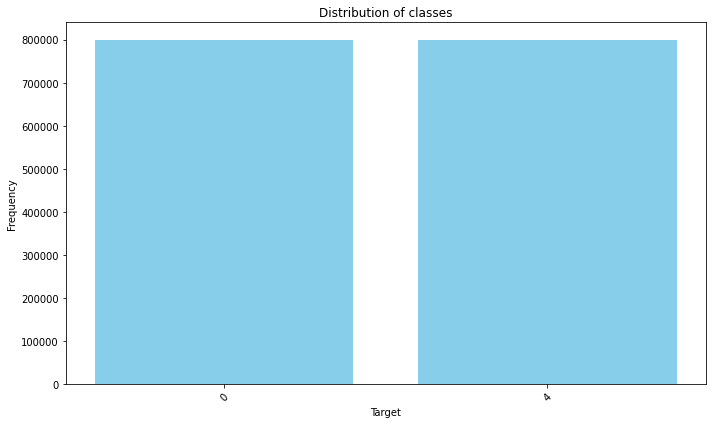

+------+------+
|Target| count|
+------+------+
|     0|800000|
|     4|800000|
+------+------+



In [ ]:
import matplotlib.pyplot as plt

grouped_data = tweetDF.groupBy("Target").count()
data = grouped_data.collect()


targets = [row["Target"] for row in data]
counts = [row["count"] for row in data]


plt.figure(figsize=(10, 6))
plt.bar(targets, counts, color='skyblue')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

tweetDF.groupBy("Target").count().show()

Counting the number of tweet for each user. "lost_dog" has the highest number of tweets : 549.

In [ ]:
from pyspark.sql.functions import desc, asc

columns = tweetDF.columns
print(columns)

tweetDF.groupBy("User").count().orderBy(desc("count")).show()


['Target', 'Ids', 'Date', 'Flag', 'User', 'Text', 'author_index']
+---------------+-----+
|           User|count|
+---------------+-----+
|       lost_dog|  549|
|        webwoke|  345|
|       tweetpet|  310|
|SallytheShizzle|  281|
|    VioletsCRUK|  279|
|    mcraddictal|  276|
|       tsarnick|  248|
|    what_bugs_u|  246|
|    Karen230683|  238|
|      DarkPiano|  236|
|   SongoftheOss|  227|
|      Jayme1988|  225|
|         keza34|  219|
| ramdomthoughts|  216|
|      shanajaca|  213|
|         wowlew|  212|
|     nuttychris|  211|
|   TraceyHewins|  211|
|   thisgoeshere|  207|
|     Spidersamm|  205|
+---------------+-----+
only showing top 20 rows



Converting "Date" column in the right format. Then are showed the first and the last tweet dates. The interval of time in which data have been recorded lasts two months, from April 2009 to June 2009.

In [ ]:
from pyspark.sql.functions import to_timestamp, col
from pyspark.sql.functions import min, max
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

tweetDF = tweetDF.withColumn("Date", to_timestamp(col("Date"), "EEE MMM dd HH:mm:ss Z yyyy"))

n = 10
last_date = tweetDF.orderBy("Date", ascending=False).limit(n).select("Date")

date_interval = tweetDF.agg(min("Date").alias("Start_Date"), max("Date").alias("End_Date"))


tweetDF.select("Date").show(10, truncate=False)
last_date.show(truncate=False)
date_interval.show()


+-------------------+
|Date               |
+-------------------+
|2009-04-07 05:19:45|
|2009-04-07 05:19:49|
|2009-04-07 05:19:53|
|2009-04-07 05:19:57|
|2009-04-07 05:19:57|
|2009-04-07 05:20:00|
|2009-04-07 05:20:03|
|2009-04-07 05:20:03|
|2009-04-07 05:20:05|
|2009-04-07 05:20:09|
+-------------------+
only showing top 10 rows

+-------------------+
|Date               |
+-------------------+
|2009-06-25 17:28:31|
|2009-06-25 17:28:30|
|2009-06-25 17:28:30|
|2009-06-25 17:28:28|
|2009-06-25 17:28:28|
|2009-06-25 17:28:28|
|2009-06-25 17:28:27|
|2009-06-25 17:28:27|
|2009-06-25 17:28:27|
|2009-06-25 17:28:26|
+-------------------+

+-------------------+-------------------+
|         Start_Date|           End_Date|
+-------------------+-------------------+
|2009-04-07 05:19:45|2009-06-25 17:28:31|
+-------------------+-------------------+



Ordering tweets by their date.

In [ ]:

tweetDF_sorted = tweetDF.orderBy(col("Date").asc())
tweetDF_sorted.show(10, truncate=False)


+------+----------+-------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+------------+
|Target|Ids       |Date               |Flag    |User           |Text                                                                                                               |author_index|
+------+----------+-------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+------------+
|0     |1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|183855.0    |
|0     |1467810672|2009-04-07 05:19:49|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |25577.0     |
|0     |1467810917|2009-04-07 

In [ ]:
from pyspark.sql.functions import when

tweetDF = tweetDF.withColumn("Sentiment",
                             when(tweetDF["Target"] == 0, "negative")
                             .when(tweetDF["Target"] == 4, "positive")
                             .otherwise("neutral"))

tweetDF.show()

+------+----------+-------------------+--------+---------------+--------------------+------------+---------+
|Target|       Ids|               Date|    Flag|           User|                Text|author_index|Sentiment|
+------+----------+-------------------+--------+---------------+--------------------+------------+---------+
|     0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|    183855.0| negative|
|     0|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|     25577.0| negative|
|     0|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|     30183.0| negative|
|     0|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|     14214.0| negative|
|     0|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|       883.0| negative|
|     0|1467811372|2009-04-07 05:20:00|NO_QUERY|       joy_wolf|@Kwesidei not the...|    518993.0| negative|
|     0|1467811592|

Preprocessing the text. Removing spaces between words, stemming words and removing unuseful strings like URL or nickname.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = []
    for token in text.split():
        if token not in stop_words:
            stemmed = stemmer.stem(token)
            lemmatized = lemmatizer.lemmatize(stemmed)
            tokens.append(lemmatized)

    return " ".join(tokens)


In [ ]:
preprocess_udf = udf(preprocess, StringType())

tweetDF = tweetDF.withColumn('processed_text', preprocess_udf(F.col('text')))


In [ ]:
tweetDF.select('text', 'processed_text').show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------+
|text                                                                                                                 |processed_text                                                   |
+---------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |awww bummer shoulda got david carr third day                     |
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!      |upset updat facebook text might cri result school today also blah|
|@Kenichan I dived many times for the ball. Managed to save 50%  The r

Splitting the dataset into train(80%) and test(20%) set. The goal is to make a fine-tuning of the pre-trained model.

In [ ]:
trainDF, testDF = tweetDF.randomSplit([0.8, 0.2], seed=42)


print(f"Training set: {trainDF.count()} records")
print(f"Test set: {testDF.count()} records")

Training set: 1280209 records
Test set: 319791 records


Using TF-IDF is much important for text preprocessing and for the numerical representation of it. It helps to take into account the importante of a word in a document, having a corpus of documents. It is also possible to show the dictionary and calculate the frequency for the most present words.

In [ ]:
df_copy = tweetDF.cache()
df_copy.show()

+------+----------+-------------------+--------+---------------+--------------------+------------+---------+--------------------+
|Target|       Ids|               Date|    Flag|           User|                Text|author_index|Sentiment|      processed_text|
+------+----------+-------------------+--------+---------------+--------------------+------------+---------+--------------------+
|     0|1467810369|2009-04-07 05:19:45|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|    183855.0| negative|awww bummer shoul...|
|     0|1467810672|2009-04-07 05:19:49|NO_QUERY|  scotthamilton|is upset that he ...|     25577.0| negative|upset updat faceb...|
|     0|1467810917|2009-04-07 05:19:53|NO_QUERY|       mattycus|@Kenichan I dived...|     30183.0| negative|dive mani time ba...|
|     0|1467811184|2009-04-07 05:19:57|NO_QUERY|        ElleCTF|my whole body fee...|     14214.0| negative|whole bodi feel i...|
|     0|1467811193|2009-04-07 05:19:57|NO_QUERY|         Karoli|@nationwideclass ...|     

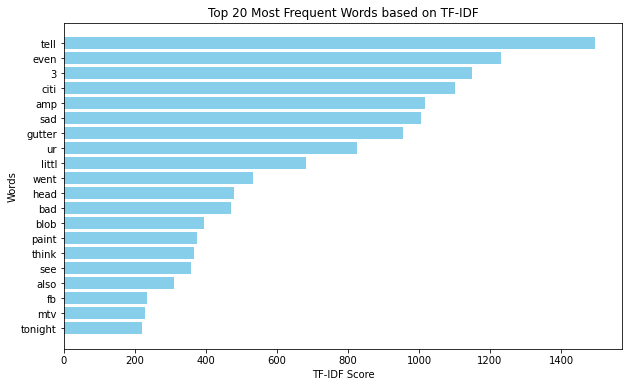

In [ ]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import explode, col, split, udf
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt

df_copy = df_copy.withColumn("processed_text", split(col("processed_text"), " "))

hashing_tf = HashingTF(inputCol="processed_text", outputCol="raw_features", numFeatures=20000)
df_copy = hashing_tf.transform(df_copy)

idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(df_copy)
df_copy = idf_model.transform(df_copy)

df_exploded = df_copy.withColumn("word", explode(col("processed_text")))

def compute_tfidf(word, features, vocab_size=20000):
    hash_index = abs(hash(word)) % vocab_size
    return float(features[hash_index]) if hash_index < len(features) else 0.0

tfidf_udf = udf(compute_tfidf, FloatType())
df_exploded = df_exploded.withColumn("score", tfidf_udf(col("word"), col("features")))

word_freq = df_exploded.groupBy("word").sum("score").withColumnRenamed("sum(score)", "score")


top_words = word_freq.orderBy(col("score").desc()).limit(20).toPandas()


plt.figure(figsize=(10, 6))
plt.barh(top_words['word'], top_words['score'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words based on TF-IDF')
plt.gca().invert_yaxis()
plt.show()


**Building text classification model.**

Logistic Regression

It is possible to apply logistic regression to build a classifier of positive and negative tweet. Data have been splitted into train and test set. After the training of the model have been made prediction on the test set. Are then produced different metrics which give information about the performance of the model (precisio, recall, F1, accuracy).

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, StringIndexer, Tokenizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

results = []


label_indexer = StringIndexer(inputCol="target", outputCol="label")


tokenizer = Tokenizer(inputCol="processed_text", outputCol="words")
vectorizer = CountVectorizer(inputCol="words", outputCol="features")


lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, regParam=0.3, elasticNetParam=0.0)

pipeline = Pipeline(stages=[label_indexer, tokenizer, vectorizer, lr])

lr_model = pipeline.fit(trainDF)

predictions_lr = lr_model.transform(testDF)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

accuracy = evaluator_accuracy.evaluate(predictions_lr)
f1_score = evaluator_f1.evaluate(predictions_lr)
precision = evaluator_precision.evaluate(predictions_lr)
recall = evaluator_recall.evaluate(predictions_lr)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


confusion_matrix = predictions_lr.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_matrix.show()

results.append({
        "Model": "Logistic Regression",
        "Accuracy": accuracy,
        "F1-Score": f1_score,
        "Precision": precision,
        "Recall": recall
    })


Accuracy: 0.7651215950417617
F1 Score: 0.7650757834742934
Precision: 0.7653772449307463
Recall: 0.7651215950417616
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|124410|
|  0.0|       1.0| 35148|
|  1.0|       0.0| 39964|
|  1.0|       1.0|120269|
+-----+----------+------+



Support vector machine

In [ ]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)


pipeline = Pipeline(stages=[label_indexer, tokenizer, vectorizer, svm])

svm_model = pipeline.fit(trainDF)


predictions_svm = svm_model.transform(testDF)


accuracy = evaluator_accuracy.evaluate(predictions_svm)
f1_score = evaluator_f1.evaluate(predictions_svm)
precision = evaluator_precision.evaluate(predictions_svm)
recall = evaluator_recall.evaluate(predictions_svm)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


confusion_matrix = predictions_svm.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_matrix.show()

results.append({
        "Model": "Support Vector Machine",
        "Accuracy": accuracy,
        "F1-Score": f1_score,
        "Precision": precision,
        "Recall": recall
    })

Accuracy: 0.7667507841058692
F1 Score: 0.7665689691055018
Precision: 0.7676786131972206
Recall: 0.7667507841058692
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|126897|
|  0.0|       1.0| 32661|
|  1.0|       0.0| 41930|
|  1.0|       1.0|118303|
+-----+----------+------+



Naive bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="features", labelCol="label")


pipeline = Pipeline(stages=[label_indexer, tokenizer, vectorizer, nb])
nb_model = pipeline.fit(trainDF)

predictions_nb = nb_model.transform(testDF)


accuracy = evaluator_accuracy.evaluate(predictions_nb)
f1_score = evaluator_f1.evaluate(predictions_nb)
precision = evaluator_precision.evaluate(predictions_nb)
recall = evaluator_recall.evaluate(predictions_nb)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

confusion_matrix = predictions_nb.groupBy("label", "prediction").count().orderBy("label", "prediction")
confusion_matrix.show()

results.append({
        "Model": "Naive Bayes",
        "Accuracy": accuracy,
        "F1-Score": f1_score,
        "Precision": precision,
        "Recall": recall
    })


Accuracy: 0.7637300611962188
F1 Score: 0.7636965257888263
Precision: 0.7638446779604013
Recall: 0.7637300611962188
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|120036|
|  0.0|       1.0| 39522|
|  1.0|       0.0| 36035|
|  1.0|       1.0|124198|
+-----+----------+------+



We create a Spark NLP Pipeline with Bert_base_sequence_classifier_imdb model. This model is a fine-tuned BERT model that is ready to be used for Sequence Classification tasks such as sentiment analysis or multi-class text classification and it achieves state-of-the-art performance.

In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import functions as F
from sparknlp.base import DocumentAssembler


print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)


Spark NLP version:  5.5.2
Apache Spark version:  3.3.2


Assembling the pretrained model and starting the pipeline.

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol('processed_text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

sequenceClassifier = BertForSequenceClassification \
    .pretrained('bert_base_sequence_classifier_imdb', 'en') \
    .setInputCols(['token', 'document']) \
    .setOutputCol('pred_class') \
    .setCaseSensitive(True) \
    .setMaxSentenceLength(512)\
    .setMultilabel(True)

pipeline = Pipeline(
    stages=[
        document_assembler,
        tokenizer,
        sequenceClassifier
])

model = pipeline.fit(trainDF)
predictions = model.transform(testDF)


bert_base_sequence_classifier_imdb download started this may take some time.
Approximate size to download 387.6 MB
[OK!]


Checking which are the classes to identify.

In [ ]:
sequenceClassifier.getClasses()

Out[58]: ['neg', 'pos']

Considering the results, are then showed text, target e predicted label for each tweet.

In [ ]:
from pyspark.sql.functions import col

predictions= predictions.withColumn("predicted_label", col("pred_class").getItem(0).getField("result"))
predictions.select("processed_text", "Target", "predicted_label").show(10, truncate=False)


+-----------------------------------------------------------------------------------+------+---------------+
|processed_text                                                                     |Target|predicted_label|
+-----------------------------------------------------------------------------------+------+---------------+
|dive mani time ball manag save 50 rest go bound                                    |0     |pos            |
|need hug                                                                           |0     |pos            |
|nope                                                                               |0     |neg            |
|count idk either never talk anymor                                                 |0     |neg            |
|oh dear drink forgotten tabl drink                                                 |0     |pos            |
|week go hope                                                                       |0     |pos            |
|meh almost lover e

In [ ]:
predictions.select("Target", "predicted_label").show(truncate=False)


+------+---------------+
|Target|predicted_label|
+------+---------------+
|0     |pos            |
|0     |pos            |
|0     |neg            |
|0     |neg            |
|0     |pos            |
|0     |pos            |
|0     |neg            |
|0     |neg            |
|0     |neg            |
|0     |neg            |
|0     |neg            |
|0     |pos            |
|0     |pos            |
|0     |neg            |
|0     |pos            |
|0     |pos            |
|0     |pos            |
|0     |neg            |
|0     |pos            |
|0     |neg            |
+------+---------------+
only showing top 20 rows



Comparing different models

+------------------+------------------+--------------------+------------------+------------------+
|          Accuracy|          F1-Score|               Model|         Precision|            Recall|
+------------------+------------------+--------------------+------------------+------------------+
|0.7651215950417617|0.7650757834742934| Logistic Regression|0.7653772449307463|0.7651215950417616|
|0.7667507841058692|0.7665689691055018|Support Vector Ma...|0.7676786131972206|0.7667507841058692|
|0.7637300611962188|0.7636965257888263|         Naive Bayes|0.7638446779604013|0.7637300611962188|
+------------------+------------------+--------------------+------------------+------------------+



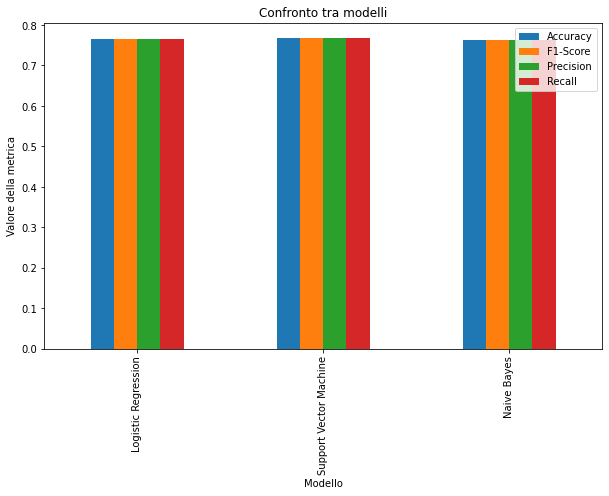

In [ ]:
results_df = spark.createDataFrame(results)

results_df.show()

results_pd = results_df.toPandas()

results_pd.set_index("Model")[["Accuracy", "F1-Score", "Precision", "Recall"]].plot(kind="bar", figsize=(10, 6))
plt.title("Confronto tra modelli")
plt.ylabel("Valore della metrica")
plt.xlabel("Modello")
plt.legend(loc="best")
plt.show()


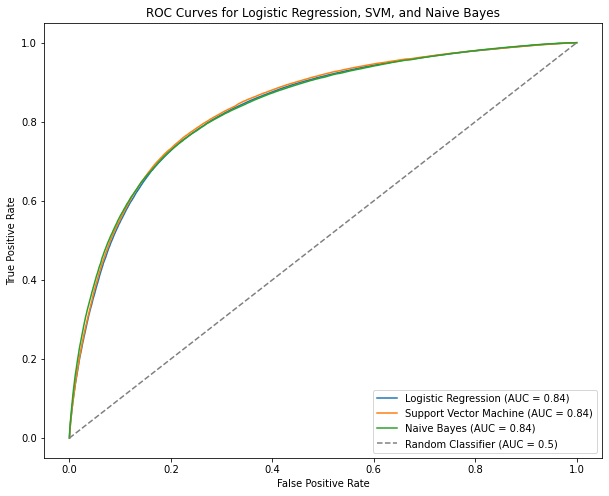

In [ ]:
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


def plot_roc_curve(predictions, model_name,column_name):
    predictions = predictions.withColumn(column_name, vector_to_array(predictions[column_name]))

    y_true = np.array(predictions.select("label").rdd.flatMap(lambda x: x).collect())
    y_scores = np.array(predictions.select(column_name).rdd.flatMap(lambda x: x).collect())

    fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))

plot_roc_curve(predictions_lr, "Logistic Regression", "probability")

plot_roc_curve(predictions_svm, "Support Vector Machine", "rawPrediction")

plot_roc_curve(predictions_nb, "Naive Bayes", "probability")

plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier (AUC = 0.5)', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression, SVM, and Naive Bayes')
plt.legend(loc='lower right')
plt.show()


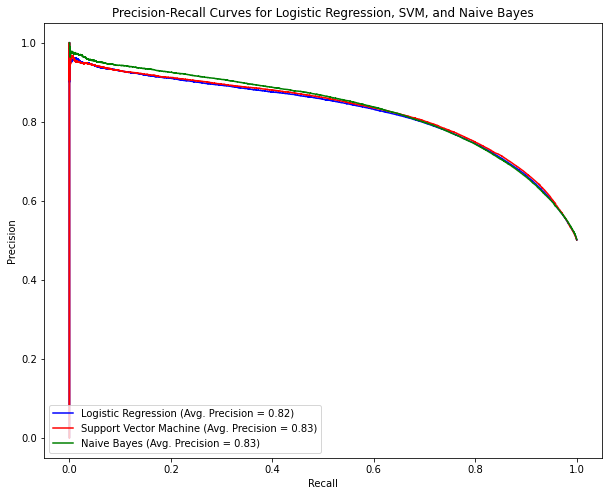

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.functions import vector_to_array

def plot_precision_recall_curve(predictions, model_name, color, column_name):
    predictions = predictions.withColumn(column_name, vector_to_array(predictions[column_name]))

    y_true = np.array(predictions.select("label").rdd.flatMap(lambda x: x).collect())
    y_scores = np.array(predictions.select(column_name).rdd.flatMap(lambda x: x).collect())

    precision, recall, _ = precision_recall_curve(y_true, y_scores[:, 1])
    avg_precision = average_precision_score(y_true, y_scores[:, 1])

    plt.plot(recall, precision, color=color, label=f'{model_name} (Avg. Precision = {avg_precision:.2f})')

plt.figure(figsize=(10, 8))

plot_precision_recall_curve(predictions_lr, "Logistic Regression", 'blue', "probability")

plot_precision_recall_curve(predictions_svm, "Support Vector Machine", 'red', "rawPrediction")

plot_precision_recall_curve(predictions_nb, "Naive Bayes", 'green', "probability")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Logistic Regression, SVM, and Naive Bayes')
plt.legend(loc='lower left')
plt.show()
